# ⚡ Energy Price Pipeline — v6
**Target: beat leaderboard RMSE 22**

### v5 results analysis:
- Recursive prediction fixed: test means now match train (Market F: 20.97 vs 19.95 ✓)
- Overall val RMSE: 39.1 | non-spike: 27.5
- **Market A is the single biggest lever**: non-spike RMSE=55 vs 12-20 for all others
  - If Market A reaches RMSE=25, overall non-spike drops to ~19 → competitive with leaderboard
- All markets hit `best_iter=5000` (model ceiling) — need lower lr + more trees
- Spike events (Apr 7, May 16) are system-wide grid events, largely unpredictable
  but contribute 42% of squared error in val (may not recur in Sep-Nov test period)

### v6 changes:
1. **lr=0.01, n_estimators=10000** — let models fully converge
2. **Cross-market mean lag** — avg recent price across other markets captures system-wide level
3. **day_of_year** — more precise seasonality than month alone
4. **Spike recency features** — hours since price exceeded 200, 500 (spike clustering effect)
5. **Market A deeper investigation** — check if price level has trended up over time
6. **Longer lags** — add 72h (3-day) lag

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

TRAIN_PATH = '../Data/train.csv'
TEST_PATH  = '../Data/test_for_participants.csv'
SUB_PATH   = '../Data/sample_submission.csv'

LAG_HOURS    = [1, 2, 3, 6, 12, 24, 48, 72, 168]   # added 72h
ROLL_WINDOWS = [6, 24, 168]
MAX_LAG      = max(LAG_HOURS + ROLL_WINDOWS)         # 168

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print('Libraries loaded ✓')

Libraries loaded ✓


In [2]:
# === LOAD & SORT ===
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sub   = pd.read_csv(SUB_PATH)

for df in [train, test]:
    df['delivery_start'] = pd.to_datetime(df['delivery_start'])
    df['delivery_end']   = pd.to_datetime(df['delivery_end'])

train = train.sort_values(['market', 'delivery_start']).reset_index(drop=True)
test  = test.sort_values(['market',  'delivery_start']).reset_index(drop=True)

print(f'Train: {train.shape} | {train.delivery_start.min()} → {train.delivery_start.max()}')
print(f'Test:  {test.shape}  | {test.delivery_start.min()} → {test.delivery_start.max()}')

# === MARKET A INVESTIGATION ===
# Check if Market A prices have trended up over time (explains val difficulty)
print('\nMarket A quarterly mean target (is it trending up?):')
tr_a = train[train['market']=='Market A'].copy()
tr_a['quarter'] = tr_a['delivery_start'].dt.to_period('Q')
print(tr_a.groupby('quarter')['target'].agg(['mean','median','std']).round(2))

print('\nAll markets quarterly mean:')
train['quarter'] = train['delivery_start'].dt.to_period('Q')
print(train.groupby(['quarter','market'])['target'].mean().unstack().round(1))
train.drop(columns=['quarter'], inplace=True)

Train: (132608, 31) | 2023-01-01 00:00:00 → 2025-08-31 23:00:00
Test:  (13098, 30)  | 2025-09-01 00:00:00 → 2025-11-30 22:00:00

Market A quarterly mean target (is it trending up?):
           mean  median     std
quarter                        
2023Q1    39.40   19.22   88.66
2023Q2    43.25   20.98  226.52
2023Q3   107.79   28.23  402.33
2023Q4    54.19   22.71  100.36
2024Q1    55.73   17.85  108.95
2024Q2    30.42   18.16  104.18
2024Q3    34.83   23.37   78.05
2024Q4    43.77   24.07   95.70
2025Q1    59.78   31.43   88.83
2025Q2    46.74   29.11   80.82
2025Q3    74.40   37.99  105.85

All markets quarterly mean:
market   Market A  Market B  Market C  Market D  Market E  Market F
quarter                                                            
2023Q1       39.4      17.4      19.6      21.3      17.7       NaN
2023Q2       43.3      33.5      30.9      35.4      33.8       NaN
2023Q3      107.8     105.8      68.6      77.9     105.7       NaN
2023Q4       54.2      21.2      

In [3]:
# === IMPUTATION ===
train['cin_was_missing'] = train['convective_inhibition'].isnull().astype(int)
test['cin_was_missing']  = test['convective_inhibition'].isnull().astype(int)
train['convective_inhibition'] = train['convective_inhibition'].fillna(0)
test['convective_inhibition']  = test['convective_inhibition'].fillna(0)

for df in [train, test]:
    df['_mc'] = LabelEncoder().fit_transform(df['market'].astype(str))
    df['_hr'] = df['delivery_start'].dt.hour

weather_null_cols = [
    c for c in train.columns
    if c not in ['id','target','market','delivery_start','delivery_end','_mc','_hr','cin_was_missing']
    and (train[c].isnull().any() or test[c].isnull().any())
]
mh_med = train.groupby(['_mc','_hr'])[weather_null_cols].median()
gl_med = train[weather_null_cols].median()

def impute_mh(df, mh, gl, cols):
    df = df.copy()
    for col in cols:
        mask = df[col].isnull()
        if not mask.any(): continue
        fill = df.loc[mask].apply(
            lambda r: mh.loc[(r['_mc'], r['_hr']), col]
            if (r['_mc'], r['_hr']) in mh.index else gl[col], axis=1)
        df.loc[mask, col] = fill.values
        df[col] = df[col].fillna(gl[col])
    return df

train = impute_mh(train, mh_med, gl_med, weather_null_cols)
test  = impute_mh(test,  mh_med, gl_med, weather_null_cols)
for df in [train, test]: df.drop(columns=['_mc','_hr'], inplace=True)
print(f'Nulls — train: {train.drop(columns=["target"]).isnull().sum().sum()}, test: {test.isnull().sum().sum()}')

Nulls — train: 0, test: 0


In [4]:
# === CROSS-MARKET LAG FEATURES ===
#
# System-wide grid events hit all markets simultaneously (Apr 7, May 16).
# If Market B is spiking, Market A probably is too.
# We add the mean and max of OTHER markets' recent prices as features.
# This is computed on train only (pivot by hour, then shift to avoid leakage).
# For test, will be handled in recursive loop using predictions from other markets.

# Pivot: one column per market, indexed by delivery_start
# Both train and test sorted by time globally (not per market) for this step
train_pivot = train[['delivery_start','market','target']].pivot(
    index='delivery_start', columns='market', values='target')

for mkt in train['market'].unique():
    other_mkts = [m for m in train['market'].unique() if m != mkt]
    # Mean and max of other markets at the same hour, shifted by 1 to avoid leakage
    other_mean = train_pivot[other_mkts].mean(axis=1).shift(1)
    other_max  = train_pivot[other_mkts].max(axis=1).shift(1)
    # Map back to train rows for this market
    mask = train['market'] == mkt
    train.loc[mask, 'cross_market_mean_lag1h'] = train.loc[mask, 'delivery_start'].map(other_mean)
    train.loc[mask, 'cross_market_max_lag1h']  = train.loc[mask, 'delivery_start'].map(other_max)

# For test: initialise with last known cross-market values from train
# Will be updated in recursive loop
last_cross_mean = train_pivot.iloc[-1].mean()
last_cross_max  = train_pivot.iloc[-1].max()
test['cross_market_mean_lag1h'] = last_cross_mean
test['cross_market_max_lag1h']  = last_cross_max

cross_nulls = train[['cross_market_mean_lag1h','cross_market_max_lag1h']].isnull().sum().sum()
print(f'Cross-market features added. Train nulls: {cross_nulls} (expected for first hour)')

Cross-market features added. Train nulls: 10 (expected for first hour)


In [5]:
# === LAG FEATURES FOR TRAIN ===

def add_train_lags(tr):
    tr = tr.copy()
    tgt = tr['target']
    for lag in LAG_HOURS:
        tr[f'target_lag_{lag}h'] = tgt.shift(lag)
    for w in ROLL_WINDOWS:
        shifted = tgt.shift(1)
        tr[f'target_roll_mean_{w}h'] = shifted.rolling(w, min_periods=1).mean()
        tr[f'target_roll_std_{w}h']  = shifted.rolling(w, min_periods=1).std().fillna(0)
        tr[f'target_roll_max_{w}h']  = shifted.rolling(w, min_periods=1).max()
        tr[f'target_roll_min_{w}h']  = shifted.rolling(w, min_periods=1).min()
    # Spike recency: hours since target exceeded threshold
    # (spike events cluster — another spike is more likely after a recent one)
    for thresh in [100, 300]:
        spike_mask = (tgt > thresh).astype(float)
        # Count hours since last spike: cumsum trick
        cum = spike_mask.cumsum()
        last_spike_idx = spike_mask.expanding().apply(
            lambda x: x[::-1].argmax() if x.sum() > 0 else len(x), raw=True)
        tr[f'hours_since_spike_{thresh}'] = last_spike_idx.shift(1).fillna(999)
        tr[f'had_spike_{thresh}_24h'] = spike_mask.shift(1).rolling(24, min_periods=1).max()
    return tr

train_parts = []
for mkt in sorted(train['market'].unique()):
    tr_m = train[train['market']==mkt].reset_index(drop=True)
    train_parts.append(add_train_lags(tr_m))
train = pd.concat(train_parts, ignore_index=True)

lag_cols = [c for c in train.columns if 'lag' in c or 'roll' in c or 'spike' in c or 'since' in c]
print(f'Lag/spike features: {len(lag_cols)}')
print(lag_cols)

Lag/spike features: 27
['cross_market_mean_lag1h', 'cross_market_max_lag1h', 'target_lag_1h', 'target_lag_2h', 'target_lag_3h', 'target_lag_6h', 'target_lag_12h', 'target_lag_24h', 'target_lag_48h', 'target_lag_72h', 'target_lag_168h', 'target_roll_mean_6h', 'target_roll_std_6h', 'target_roll_max_6h', 'target_roll_min_6h', 'target_roll_mean_24h', 'target_roll_std_24h', 'target_roll_max_24h', 'target_roll_min_24h', 'target_roll_mean_168h', 'target_roll_std_168h', 'target_roll_max_168h', 'target_roll_min_168h', 'hours_since_spike_100', 'had_spike_100_24h', 'hours_since_spike_300', 'had_spike_300_24h']


In [6]:
# === FEATURE ENGINEERING ===

def add_features(df):
    df = df.copy()
    df['hour']         = df['delivery_start'].dt.hour
    df['day_of_week']  = df['delivery_start'].dt.dayofweek
    df['month']        = df['delivery_start'].dt.month
    df['day_of_year']  = df['delivery_start'].dt.dayofyear  # NEW: more precise seasonality
    df['week_of_year'] = df['delivery_start'].dt.isocalendar().week.astype(int)
    df['is_weekend']   = (df['day_of_week'] >= 5).astype(int)
    df['is_peak']      = df['hour'].between(7, 20).astype(int)
    df['hour_sin']     = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']     = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin']    = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos']    = np.cos(2 * np.pi * df['month'] / 12)
    df['doy_sin']      = np.sin(2 * np.pi * df['day_of_year'] / 365)  # NEW
    df['doy_cos']      = np.cos(2 * np.pi * df['day_of_year'] / 365)  # NEW
    df['dow_sin']      = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos']      = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['solar_ratio']        = df['global_horizontal_irradiance'] / (df['direct_normal_irradiance'] + 1)
    df['diffuse_ratio']      = df['diffuse_horizontal_irradiance'] / (df['global_horizontal_irradiance'] + 1)
    df['solar_any']          = (df['global_horizontal_irradiance'] > 0).astype(int)
    df['solar_forecast_gap'] = df['solar_forecast'] - df['global_horizontal_irradiance']
    df['solar_frac_of_load'] = df['solar_forecast'] / (df['load_forecast'] + 1)
    df['cloud_weighted']     = 0.5*df['cloud_cover_low'] + 0.3*df['cloud_cover_mid'] + 0.2*df['cloud_cover_high']
    df['wind_speed_delta']   = df['wind_speed_80m'] - df['wind_speed_10m']
    df['wind_dir_sin']       = np.sin(np.radians(df['wind_direction_80m']))
    df['wind_dir_cos']       = np.cos(np.radians(df['wind_direction_80m']))
    df['wind_gust_ratio']    = df['wind_gust_speed_10m'] / (df['wind_speed_10m'] + 0.01)
    df['wind_forecast_gap']  = df['wind_forecast'] - df['wind_speed_10m']
    df['wind_frac_of_load']  = df['wind_forecast'] / (df['load_forecast'] + 1)
    df['renewable_frac']     = (df['solar_forecast'] + df['wind_forecast']) / (df['load_forecast'] + 1)
    df['temp_apparent_delta'] = df['apparent_temperature_2m'] - df['air_temperature_2m']
    df['temp_dewpoint_delta'] = df['air_temperature_2m'] - df['dew_point_temperature_2m']
    df['spike_risk']         = df['load_forecast'] * (1 - df['renewable_frac']) * df['is_peak']
    df['market_code']        = LabelEncoder().fit_transform(df['market'].astype(str))
    return df

train = add_features(train)
test  = add_features(test)
print('Features added ✓')

Features added ✓


In [7]:
# === OUTLIER WINSORIZATION ===
WINSOR_UPPER = train['target'].quantile(0.9995)
WINSOR_LOWER = train['target'].quantile(0.0005)
print(f'Winsorization: [{WINSOR_LOWER:.1f}, {WINSOR_UPPER:.1f}]')
train['target_raw']    = train['target'].copy()
train['target_winsor'] = train['target'].clip(WINSOR_LOWER, WINSOR_UPPER)
train['is_spike']      = ((train['target'] > WINSOR_UPPER) | (train['target'] < WINSOR_LOWER)).astype(int)

Winsorization: [-90.6, 3243.3]


In [8]:
# === DEFINE FEATURES ===
DROP_COLS    = ['id', 'target', 'target_raw', 'target_winsor', 'is_spike',
                'market', 'delivery_start', 'delivery_end']
FEATURE_COLS = [c for c in train.columns if c not in DROP_COLS]

# Initialise spike recency features in test (no history yet — will update in recursive loop)
for thresh in [100, 300]:
    test[f'hours_since_spike_{thresh}'] = 999.0
    test[f'had_spike_{thresh}_24h']     = 0.0

train_model = train.dropna(subset=['target_lag_1h']).reset_index(drop=True)
print(f'Train rows: {len(train_model)} | Features: {len(FEATURE_COLS)}')
print(f'New features vs v5: cross_market_mean/max_lag1h, day_of_year, doy_sin/cos, 72h lag, spike recency')

Train rows: 132602 | Features: 86
New features vs v5: cross_market_mean/max_lag1h, day_of_year, doy_sin/cos, 72h lag, spike recency


In [9]:
import torch as th
#print(f'Using device: {"GPU" if th.cuda.is_available() else "CPU"}')
# === PER-MARKET TRAINING ===
# Lower lr (0.01) + more trees (10000) to let all markets fully converge.
# v5 showed best_iter=5000 for all markets (ceiling was hit).

lgb_params = {
    'objective':         'huber',
    'alpha':             0.9,
    'metric':            'huber',
    'learning_rate':     0.25,    # lowered from 0.03
    'num_leaves':        127,
    'min_child_samples': 20,
    'feature_fraction':  0.8,
    'bagging_fraction':  0.8,
    'bagging_freq':      1,
    'reg_alpha':         0.1,
    'reg_lambda':        0.1,
    'n_estimators':      5000,   # raised from 5000
    'verbose':          -1,
    'n_jobs':           -1,
    'random_state':      42,
    "device":          "cpu"     if th.cuda.is_available() else "cpu"
}

market_models = {}
oof_store     = []

for mkt in sorted(train_model['market'].unique()):
    tr_m  = train_model[train_model['market'] == mkt].reset_index(drop=True)
    X_m   = tr_m[FEATURE_COLS]
    y_w   = tr_m['target_winsor']
    y_raw = tr_m['target_raw']

    split = int(len(X_m) * 0.8)

    val_model = lgb.LGBMRegressor(**lgb_params)
    val_model.fit(
        X_m.iloc[:split], y_w.iloc[:split],
        eval_set=[(X_m.iloc[split:], y_w.iloc[split:])],
        callbacks=[lgb.early_stopping(300, verbose=False), lgb.log_evaluation(-1)]
    )
    val_preds = val_model.predict(X_m.iloc[split:])
    val_rmse  = rmse(y_raw.iloc[split:], val_preds)
    val_rmse_ns = rmse(
        y_raw.iloc[split:][y_raw.iloc[split:] <= 500],
        pd.Series(val_preds)[y_raw.iloc[split:].values <= 500]
    )

    oof_store.append(pd.DataFrame({
        'market':         mkt,
        'target':         y_raw.iloc[split:].values,
        'pred':           val_preds,
        'is_spike':       tr_m['is_spike'].iloc[split:].values,
        'delivery_start': tr_m['delivery_start'].iloc[split:].values,
        'hour':           tr_m['hour'].iloc[split:].values,
    }))

    best_iter = val_model.best_iteration_
    final_model = lgb.LGBMRegressor(**{**lgb_params, 'n_estimators': best_iter + 100})
    final_model.fit(X_m, y_w)
    market_models[mkt] = final_model

    print(f'  {mkt}: RMSE={val_rmse:.2f} (excl spikes={val_rmse_ns:.2f})  best_iter={best_iter}')

oof_df = pd.concat(oof_store, ignore_index=True)
print(f'\n✅ Overall val RMSE: {rmse(oof_df["target"], oof_df["pred"]):.4f}')
print(f'   Non-spike (≤500): {rmse(oof_df[oof_df["target"]<=500]["target"], oof_df[oof_df["target"]<=500]["pred"]):.4f}')

  Market A: RMSE=55.18 (excl spikes=44.26)  best_iter=3793
  Market B: RMSE=33.90 (excl spikes=17.49)  best_iter=2107
  Market C: RMSE=25.08 (excl spikes=15.06)  best_iter=1631
  Market D: RMSE=25.94 (excl spikes=16.53)  best_iter=633
  Market E: RMSE=33.99 (excl spikes=17.53)  best_iter=2178
  Market F: RMSE=12.71 (excl spikes=12.71)  best_iter=530

✅ Overall val RMSE: 34.5190
   Non-spike (≤500): 23.6648


In [10]:
# === RECURSIVE TEST PREDICTION WITH CROSS-MARKET TRACKING ===
#
# Now we also track predictions across markets to update the
# cross_market_mean/max features in real time.
# Markets are processed in alphabetical order; each market's prediction
# at hour t is available to subsequent markets at hour t+1.

NON_LAG_COLS  = [c for c in FEATURE_COLS
                 if 'lag' not in c and 'roll' not in c
                 and 'had_spike' not in c and 'since' not in c
                 and 'cross_market' not in c]
LAG_FEAT_COLS = [c for c in FEATURE_COLS if c not in NON_LAG_COLS]

def get_lag_features(buffer, hours_since_spike_100, hours_since_spike_300,
                     had_spike_100_24h, had_spike_300_24h):
    feats = {}
    n = len(buffer)
    for lag in LAG_HOURS:
        feats[f'target_lag_{lag}h'] = buffer[-lag] if n >= lag else np.nan
    for w in ROLL_WINDOWS:
        window = list(buffer[-w:]) if n >= w else list(buffer)
        feats[f'target_roll_mean_{w}h'] = np.mean(window)
        feats[f'target_roll_std_{w}h']  = np.std(window) if len(window) > 1 else 0.0
        feats[f'target_roll_max_{w}h']  = np.max(window)
        feats[f'target_roll_min_{w}h']  = np.min(window)
    feats['hours_since_spike_100'] = hours_since_spike_100
    feats['hours_since_spike_300'] = hours_since_spike_300
    feats['had_spike_100_24h']     = had_spike_100_24h
    feats['had_spike_300_24h']     = had_spike_300_24h
    return feats

all_test_preds = {}     # mkt -> list of predictions
# Cross-market buffer: stores last prediction per market for cross-market features
cross_market_buffer = {mkt: list(train[train['market']==mkt]['target_raw'].tail(MAX_LAG).values)
                       for mkt in market_models}

# Process all markets hour-by-hour in sync so cross-market lags are consistent
markets_sorted = sorted(market_models.keys())
n_test = len(test[test['market'] == markets_sorted[0]])

# Collect test rows per market, sorted by time
test_by_market = {
    mkt: test[test['market']==mkt].sort_values('delivery_start').reset_index(drop=True)
    for mkt in markets_sorted
}
train_by_market = {
    mkt: train[train['market']==mkt].sort_values('delivery_start')
    for mkt in markets_sorted
}

# Per-market buffers and spike tracking
target_buffers = {
    mkt: list(train_by_market[mkt]['target_raw'].tail(MAX_LAG).values)
    for mkt in markets_sorted
}
spike_buffers_100 = {mkt: list(train_by_market[mkt]['target_raw'].tail(24).values)
                     for mkt in markets_sorted}
spike_buffers_300 = {mkt: list(train_by_market[mkt]['target_raw'].tail(24).values)
                     for mkt in markets_sorted}
hours_since_spike = {mkt: {100: 999, 300: 999} for mkt in markets_sorted}

preds_by_market = {mkt: [] for mkt in markets_sorted}

for i in range(n_test):
    hour_preds = {}   # predictions for all markets at this hour

    for mkt in markets_sorted:
        model  = market_models[mkt]
        row    = test_by_market[mkt].iloc[i]
        buf    = target_buffers[mkt]

        # Cross-market features: mean/max of OTHER markets' most recent predictions
        other_recent = [target_buffers[m][-1] for m in markets_sorted if m != mkt]
        cross_mean = np.mean(other_recent)
        cross_max  = np.max(other_recent)

        # Spike recency
        had_100 = int(any(v > 100 for v in spike_buffers_100[mkt]))
        had_300 = int(any(v > 300 for v in spike_buffers_300[mkt]))

        lag_feats = get_lag_features(
            buf,
            hours_since_spike[mkt][100],
            hours_since_spike[mkt][300],
            had_100, had_300
        )

        feat_row = {col: row[col] for col in NON_LAG_COLS}
        feat_row.update(lag_feats)
        feat_row['cross_market_mean_lag1h'] = cross_mean
        feat_row['cross_market_max_lag1h']  = cross_max

        X_row = pd.DataFrame([feat_row])[FEATURE_COLS]
        pred  = model.predict(X_row)[0]
        preds_by_market[mkt].append(pred)
        hour_preds[mkt] = pred

    # Update all buffers AFTER all markets predicted at this hour
    for mkt in markets_sorted:
        pred = hour_preds[mkt]
        target_buffers[mkt].append(pred)
        if len(target_buffers[mkt]) > MAX_LAG + 1:
            target_buffers[mkt].pop(0)
        spike_buffers_100[mkt].append(pred)
        spike_buffers_300[mkt].append(pred)
        if len(spike_buffers_100[mkt]) > 24: spike_buffers_100[mkt].pop(0)
        if len(spike_buffers_300[mkt]) > 24: spike_buffers_300[mkt].pop(0)
        hours_since_spike[mkt][100] = 0 if pred > 100 else min(hours_since_spike[mkt][100] + 1, 999)
        hours_since_spike[mkt][300] = 0 if pred > 300 else min(hours_since_spike[mkt][300] + 1, 999)

    if i % 500 == 0:
        print(f'  Step {i}/{n_test} ...', {m: f'{hour_preds[m]:.1f}' for m in markets_sorted})

print('\nRecursive prediction complete ✓')
for mkt in markets_sorted:
    p = preds_by_market[mkt]
    print(f'  {mkt}: mean={np.mean(p):.2f}, std={np.std(p):.2f}, min={np.min(p):.2f}, max={np.max(p):.2f}')

  Step 0/2183 ... {'Market A': '289.1', 'Market B': '38.8', 'Market C': '31.3', 'Market D': '31.6', 'Market E': '35.1', 'Market F': '28.6'}
  Step 500/2183 ... {'Market A': '52.2', 'Market B': '22.8', 'Market C': '53.6', 'Market D': '34.8', 'Market E': '22.7', 'Market F': '34.7'}
  Step 1000/2183 ... {'Market A': '13.8', 'Market B': '8.9', 'Market C': '22.6', 'Market D': '20.7', 'Market E': '13.4', 'Market F': '16.9'}
  Step 1500/2183 ... {'Market A': '9.0', 'Market B': '1.9', 'Market C': '3.7', 'Market D': '2.5', 'Market E': '6.0', 'Market F': '8.4'}
  Step 2000/2183 ... {'Market A': '22.6', 'Market B': '23.6', 'Market C': '26.4', 'Market D': '25.3', 'Market E': '26.1', 'Market F': '24.5'}

Recursive prediction complete ✓
  Market A: mean=36.66, std=37.00, min=-20.54, max=393.01
  Market B: mean=21.48, std=14.70, min=-10.41, max=128.45
  Market C: mean=29.95, std=14.13, min=-14.74, max=95.50
  Market D: mean=26.01, std=9.05, min=-12.12, max=72.46
  Market E: mean=20.60, std=13.97, min

In [11]:
# === ASSEMBLE & SAVE SUBMISSION ===

# Map predictions back by id (test was sorted by market+time, sub has different order)
pred_map = {}
for mkt in markets_sorted:
    te_ids = test_by_market[mkt]['id'].values
    for id_, pred in zip(te_ids, preds_by_market[mkt]):
        pred_map[id_] = pred

sub['target'] = sub['id'].map(pred_map)
sub.to_csv('submission.csv', index=False)
print('submission.csv saved ✓')
print(sub['target'].describe())

print(f'\nSanity — train target: mean={train["target_raw"].mean():.2f}, median={train["target_raw"].median():.2f}')
print(f'         test preds:  mean={sub["target"].mean():.2f},  median={sub["target"].median():.2f}')

print('\nPer-market (train mean vs test pred mean):')
for mkt in markets_sorted:
    tr_mean = train[train['market']==mkt]['target_raw'].mean()
    te_mean = np.mean(preds_by_market[mkt])
    print(f'  {mkt}: train={tr_mean:.2f}, test={te_mean:.2f}')

submission.csv saved ✓
count    13098.000000
mean        26.285526
std         19.773150
min        -20.539106
25%         16.870175
50%         23.289852
75%         31.344047
max        393.011386
Name: target, dtype: float64

Sanity — train target: mean=33.91, median=20.55
         test preds:  mean=26.29,  median=23.29

Per-market (train mean vs test pred mean):
  Market A: train=53.08, test=36.66
  Market B: train=31.79, test=21.48
  Market C: train=29.69, test=29.95
  Market D: train=32.44, test=26.01
  Market E: train=31.95, test=20.60
  Market F: train=19.95, test=23.00


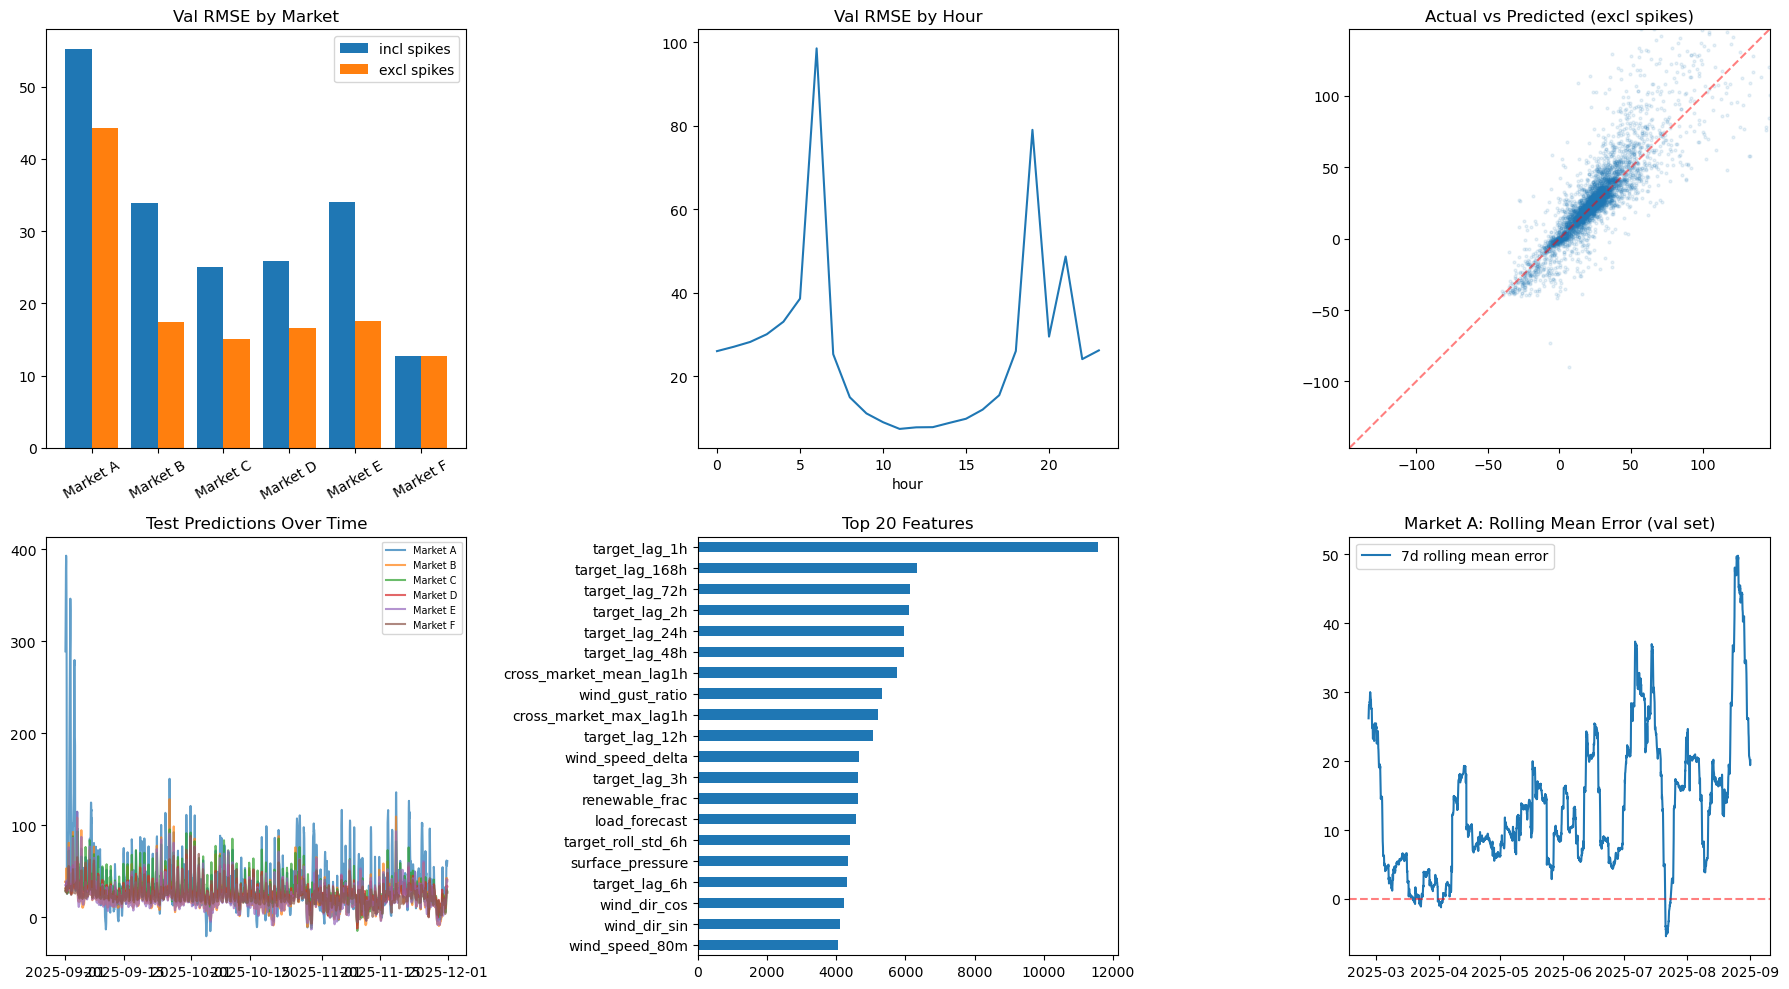

Top 15 features (avg across markets):
target_lag_1h              11562.500000
target_lag_168h             6329.500000
target_lag_72h              6130.500000
target_lag_2h               6104.166667
target_lag_24h              5950.833333
target_lag_48h              5943.500000
cross_market_mean_lag1h     5743.000000
wind_gust_ratio             5334.333333
cross_market_max_lag1h      5198.833333
target_lag_12h              5046.500000
wind_speed_delta            4647.166667
target_lag_3h               4631.000000
renewable_frac              4617.500000
load_forecast               4576.166667
target_roll_std_6h          4402.000000

New feature importances:
cross_market_mean_lag1h    5743.000000
cross_market_max_lag1h     5198.833333
doy_sin                    2544.166667
doy_cos                    1994.500000
day_of_year                2089.166667
hours_since_spike_100      2546.166667
hours_since_spike_300      3413.833333
had_spike_100_24h             2.166667
had_spike_300_24h       

In [12]:
# === DIAGNOSTICS ===

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Val RMSE by market (with and without spikes)
mkt_rmse    = oof_df.groupby('market').apply(lambda g: rmse(g['target'], g['pred']))
mkt_rmse_ns = oof_df[oof_df['target']<=500].groupby('market').apply(lambda g: rmse(g['target'], g['pred']))
x = range(len(mkt_rmse))
axes[0,0].bar([i-0.2 for i in x], mkt_rmse.values, 0.4, label='incl spikes')
axes[0,0].bar([i+0.2 for i in x], mkt_rmse_ns.values, 0.4, label='excl spikes')
axes[0,0].set_xticks(list(x)); axes[0,0].set_xticklabels(mkt_rmse.index, rotation=30)
axes[0,0].legend(); axes[0,0].set_title('Val RMSE by Market')

# Val RMSE by hour
oof_df.groupby('hour').apply(lambda g: rmse(g['target'], g['pred'])).plot(
    ax=axes[0,1], title='Val RMSE by Hour')

# Actual vs predicted
sample = oof_df[oof_df['target']<=500].sample(min(5000,len(oof_df)), random_state=42)
axes[0,2].scatter(sample['pred'], sample['target'], alpha=0.1, s=4)
lim = sample['target'].abs().quantile(0.98)
axes[0,2].set_xlim(-lim,lim); axes[0,2].set_ylim(-lim,lim)
axes[0,2].plot([-lim,lim],[-lim,lim],'r--',alpha=0.5)
axes[0,2].set_title('Actual vs Predicted (excl spikes)')

# Test predictions over time per market
te_times = test_by_market[markets_sorted[0]]['delivery_start'].values
for mkt in markets_sorted:
    axes[1,0].plot(te_times, preds_by_market[mkt], alpha=0.7, label=mkt)
axes[1,0].set_title('Test Predictions Over Time'); axes[1,0].legend(fontsize=7)

# Feature importance
imp_df = pd.DataFrame(index=FEATURE_COLS)
for mkt, model in market_models.items():
    imp_df[mkt] = model.feature_importances_
imp_df['mean'] = imp_df.mean(axis=1)
imp_df = imp_df.sort_values('mean', ascending=False)
imp_df['mean'].head(20).plot(kind='barh', ax=axes[1,1], title='Top 20 Features')
axes[1,1].invert_yaxis()

# Market A: val residuals over time
oof_a = oof_df[oof_df['market']=='Market A'].copy()
oof_a['delivery_start'] = pd.to_datetime(oof_a['delivery_start'])
oof_a = oof_a.sort_values('delivery_start')
oof_a['error'] = oof_a['target'] - oof_a['pred']
axes[1,2].plot(oof_a['delivery_start'], oof_a['error'].rolling(24*7).mean(), label='7d rolling mean error')
axes[1,2].axhline(0, color='r', linestyle='--', alpha=0.5)
axes[1,2].set_title('Market A: Rolling Mean Error (val set)')
axes[1,2].legend()

plt.tight_layout()
plt.show()

print('Top 15 features (avg across markets):')
print(imp_df['mean'].head(15).to_string())
print('\nNew feature importances:')
new_feats = ['cross_market_mean_lag1h','cross_market_max_lag1h',
             'doy_sin','doy_cos','day_of_year',
             'hours_since_spike_100','hours_since_spike_300',
             'had_spike_100_24h','had_spike_300_24h','target_lag_72h']
print(imp_df.loc[[f for f in new_feats if f in imp_df.index], 'mean'].to_string())